<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S7/S7_AssignmentSolution(NM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load required libraries**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR
import torchvision

In [0]:
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize(0.5, 0.5, 0.5)])

# Load Train & Test Dataset

train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=4)

test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False, num_workers=4)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Show some Images**

  car   car  deer   cat


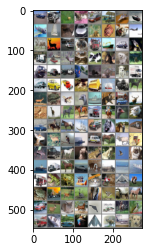

In [0]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize this is make sure the image is visible, if this step is skipped then the resulting images have a dark portion
    npimg = img.numpy()   # converting image to numpy array format
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    # transposing npimg array


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F


class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, input, output, padding=0, bias=False):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(input, input, kernel_size=3, padding=padding, groups=input, bias=bias)
        self.pointwise = nn.Conv2d(input, output, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class seaFarNet(nn.Module): # concise model
    def __init__(self, name="Model"):
        super(seaFarNet, self).__init__()
        self.name = name


# Conv Block1 
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), padding = 2, bias = False), 
            nn.ReLU(),
            nn.BatchNorm2d(16)) # O/P: 34  RF: 3
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(32)) # O/P: 34  RF: 5

      # Dilated Convolution 1
        self.dilatedconv1 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), padding = 1, dilation = 2, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 32  RF: 9

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 1 ,  bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 32  RF: 11


# Transition Block 1
        self.pool1 = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 16  RF: 12
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = (1,1), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(32)) # O/P: 18  RF: 12      
        

# ConvBlock 2
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 18  RF: 16

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), padding = 1, dilation = 2,  bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(128)) # O/P: 16  RF: 24


# Transition Block 2  
        self.pool2 = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 8  RF: 26

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = (1,1), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(32)) # O/P: 10  RF: 26


# ConvBlock 3
        self.dwconv1 = nn.Sequential(
            DepthwiseSeparableConv2d(32, 64, padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 10  RF: 34

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 10  RF: 42


# Transition Block 3 
        self.pool3 = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 5  RF: 46

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (1,1), padding = 0, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(128)) # O/P: 5  RF: 46


# ConvBlock 4
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), padding = 0, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(128)) # O/P: 3  RF: 62

        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (1,1), padding = 0, bias = False))
          # nn.ReLU(),
          # nn.BatchNorm2d(512)) # O/P: 3  RF: 62
       

    # GAP + FC
        self.gap = nn.Sequential(nn.AvgPool2d(3))
    # Last Layer
        self.conv12 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels=10, kernel_size=(1,1), padding=0, bias=False)) # O/P:3  RF: 62


    # Dropout Layer
        self.drop = nn.Sequential(nn.Dropout(0.10))




    def forward(self, x):
        x = self.conv1(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.dilatedconv1(x)
        x = self.drop(x)
        x = self.conv3(x)
        x = self.drop(x)

        x = self.pool1(x)
        x = self.conv4(x)
        x = self.drop(x)
        x = self.conv5(x)
        x = self.drop(x)
        x = self.conv6(x)
        x = self.drop(x)

        x = self.pool2(x)
        x = self.conv7(x)
        x = self.drop(x)
        x = self.dwconv1(x)
        x = self.conv8(x)
        x = self.drop(x)

        x = self.pool3(x)
        x = self.conv9(x)
        x = self.drop(x)
        x = self.conv10(x)
        x = self.drop(x)
        x = self.conv11(x) 
        
        x = self.gap(x)
        x = self.conv12(x)


        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


model = seaFarNet()


In [0]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F


class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, input, output, padding=0, bias=False):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(input, input, kernel_size=3, padding=padding, groups=input, bias=bias)
        self.pointwise = nn.Conv2d(input, output, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class cfarResNet(nn.Module): # concise model
    def __init__(self, name="Model"):
        super(cfarResNet, self).__init__()
        self.name = name


# Conv Block1 
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), padding = 2, bias = False), 
            nn.ReLU(),
            nn.BatchNorm2d(16)) # O/P: 34  RF: 3
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(32)) # O/P: 34  RF: 5

      # Dilated Convolution 1
        self.dilatedconv1 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), padding = 1, dilation = 2, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(32)) # O/P: 32  RF: 9

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), padding = 1 ,  bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(32)) # O/P: 32  RF: 11


# Transition Block 1
        self.pool1 = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 16  RF: 12
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (1,1), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 18  RF: 12      
        

# ConvBlock 2
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 18  RF: 16

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 1, dilation = 2,  bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 16  RF: 24


# Transition Block 2  
        self.pool2 = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 8  RF: 26

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = (1,1), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(32)) # O/P: 10  RF: 26


# ConvBlock 3
        self.dwconv1 = nn.Sequential(
            DepthwiseSeparableConv2d(32, 64, padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 10  RF: 34

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64)) # O/P: 10  RF: 42


# Transition Block 3 
        self.pool3 = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 5  RF: 46

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (1,1), padding = 0, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(128)) # O/P: 5  RF: 46


# ConvBlock 4
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), padding = 0, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(128)) # O/P: 3  RF: 62

        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (1,1), padding = 0, bias = False))
          # nn.ReLU(),
          # nn.BatchNorm2d(512)) # O/P: 3  RF: 62
       

    # GAP + FC
        self.gap = nn.Sequential(nn.AvgPool2d(3))
    # Last Layer
        self.conv12 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels=10, kernel_size=(1,1), padding=0, bias=False)) # O/P:3  RF: 62


    # Dropout Layer
        self.drop = nn.Sequential(nn.Dropout(0.10))




    def forward(self, x):
        x = self.conv1(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.dilatedconv1(x)
        x = self.drop(x)
        x = self.conv3(x)
        x = self.drop(x)

        x = self.pool1(x)
        x = self.conv4(x)
        x = self.drop(x)
        x = self.conv5(x)
        x = self.drop(x)
        x = self.conv6(x)
        x = self.drop(x)

        x = self.pool2(x)
        x = self.conv7(x)
        x = self.drop(x)
        x = self.dwconv1(x)
        x = self.conv8(x)
        x = self.drop(x)

        x = self.pool3(x)
        x = self.conv9(x)
        x = self.drop(x)
        x = self.conv10(x)
        x = self.drop(x)
        x = self.conv11(x) 
        
        x = self.gap(x)
        x = self.conv12(x)


        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


model = cfarResNet()


In [0]:

# Model Summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = cfarResNet(False).to(device)
summary(model, input_size=(3, 32, 32))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 34, 34]             432
              ReLU-2           [-1, 16, 34, 34]               0
       BatchNorm2d-3           [-1, 16, 34, 34]              32
           Dropout-4           [-1, 16, 34, 34]               0
            Conv2d-5           [-1, 32, 34, 34]           4,608
              ReLU-6           [-1, 32, 34, 34]               0
       BatchNorm2d-7           [-1, 32, 34, 34]              64
           Dropout-8           [-1, 32, 34, 34]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
             ReLU-14           [-1

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, trainloader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  
      test_loss /= len(testloader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))
    
      self.test_acc.append(100. * correct / len(testloader.dataset))



In [0]:
# model = seaFarNet().to(device)
model = cfarResNet().to(device)

 # this object, model of Net() class is passed onto Test_Train() object model's method train & test
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(trainloader), epochs=10)

model1 = Test_Train()
EPOCHS = 10
for epoch in range(1,EPOCHS+1):
  print("EPOCH:", epoch)
  model1.train(model, device, trainloader, optimizer, epoch, scheduler, L1lambda=1e-5)
  model1.test(model, device, testloader,"model.pt")

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.1592292785644531 Batch_id=390 Accuracy=41.52: 100%|██████████| 391/391 [00:16<00:00, 23.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.2049).  Saving model ...

Test set: Average loss: 1.2049, Accuracy: 5715/10000 (57.15%)

EPOCH: 2


Loss=0.8470920920372009 Batch_id=390 Accuracy=61.59: 100%|██████████| 391/391 [00:16<00:00, 23.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.2049 --> 0.9791).  Saving model ...

Test set: Average loss: 0.9791, Accuracy: 6559/10000 (65.59%)

EPOCH: 3


Loss=1.0060752630233765 Batch_id=390 Accuracy=70.07: 100%|██████████| 391/391 [00:16<00:00, 23.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.9791 --> 0.8797).  Saving model ...

Test set: Average loss: 0.8797, Accuracy: 6921/10000 (69.21%)

EPOCH: 4


Loss=0.6830778121948242 Batch_id=390 Accuracy=74.32: 100%|██████████| 391/391 [00:16<00:00, 23.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.8797 --> 0.7467).  Saving model ...

Test set: Average loss: 0.7467, Accuracy: 7421/10000 (74.21%)

EPOCH: 5


Loss=0.9111471772193909 Batch_id=390 Accuracy=77.34: 100%|██████████| 391/391 [00:16<00:00, 23.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.7467 --> 0.7179).  Saving model ...

Test set: Average loss: 0.7179, Accuracy: 7548/10000 (75.48%)

EPOCH: 6


Loss=0.7912999391555786 Batch_id=390 Accuracy=79.43: 100%|██████████| 391/391 [00:16<00:00, 23.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.7179 --> 0.6288).  Saving model ...

Test set: Average loss: 0.6288, Accuracy: 7827/10000 (78.27%)

EPOCH: 7


Loss=0.5730074048042297 Batch_id=390 Accuracy=81.47: 100%|██████████| 391/391 [00:16<00:00, 23.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.6288 --> 0.6062).  Saving model ...

Test set: Average loss: 0.6062, Accuracy: 7890/10000 (78.90%)

EPOCH: 8


Loss=0.7008193731307983 Batch_id=390 Accuracy=83.61: 100%|██████████| 391/391 [00:16<00:00, 24.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.6062 --> 0.5399).  Saving model ...

Test set: Average loss: 0.5399, Accuracy: 8172/10000 (81.72%)

EPOCH: 9


Loss=0.5770255327224731 Batch_id=390 Accuracy=86.20: 100%|██████████| 391/391 [00:16<00:00, 23.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.5399 --> 0.5083).  Saving model ...

Test set: Average loss: 0.5083, Accuracy: 8302/10000 (83.02%)

EPOCH: 10


Loss=0.40661755204200745 Batch_id=390 Accuracy=88.22: 100%|██████████| 391/391 [00:16<00:00, 23.72it/s]


Validation loss has  decreased (0.5083 --> 0.4987).  Saving model ...

Test set: Average loss: 0.4987, Accuracy: 8345/10000 (83.45%)



Text(0.5, 1.0, 'Test Accuracy')

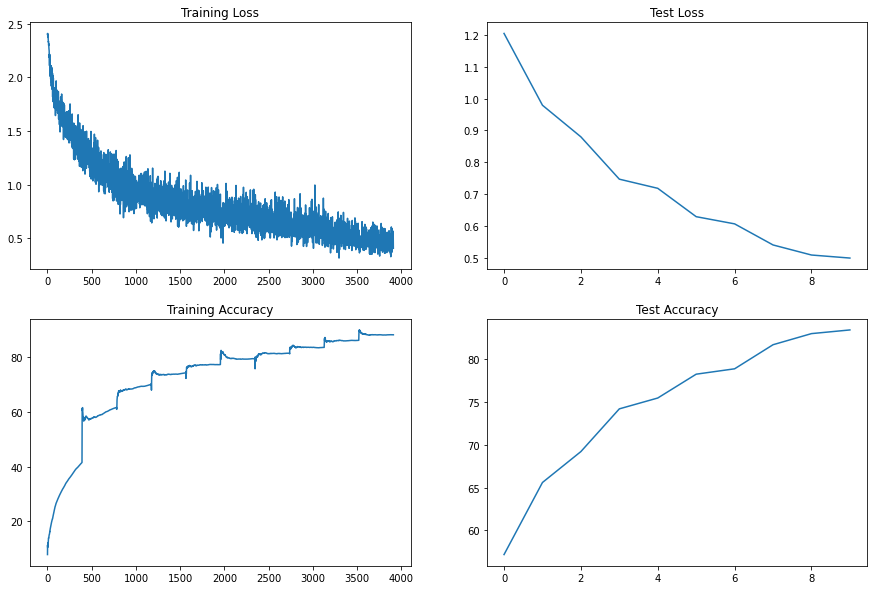

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(model1.train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(model1.train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(model1.test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(model1.test_acc)
axs[1, 1].set_title("Test Accuracy")